In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
df_stock = pd.read_csv("tata_steel/TATASTEEL.NS (1).csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("tata_steel/tata_steel_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# loading the sentiment analysis model
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()

In [2]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros_scaled = mms.fit_transform(final_x_zeros)
final_x_zeros_scaled

array([[1.        , 1.        , 0.92046785, ..., 0.61153865, 0.65435797,
        0.3703704 ],
       [0.9643564 , 0.95261765, 0.8757601 , ..., 0.60906065, 0.653799  ,
        0.3703704 ],
       [0.9023552 , 0.9144387 , 0.87307405, ..., 0.644997  , 0.72215   ,
        0.3703704 ],
       ...,
       [0.19422102, 0.19682264, 0.3645649 , ..., 0.15078813, 0.37580585,
        0.25925925],
       [0.19231653, 0.22312021, 0.4111023 , ..., 0.341228  , 0.75171083,
        0.25925925],
       [0.18178844, 0.23177814, 0.43634176, ..., 0.47385803, 0.75227636,
        0.25925925]], dtype=float32)

In [3]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k
final_y_zeros

,Close
Date,
2021-11-15,0.992826
2021-11-16,0.979553
2021-11-17,0.972578
2021-11-18,0.945913
2021-11-22,0.928734
...,...
2022-02-07,0.943043
2022-02-08,0.972219
2022-02-09,0.974411


In [4]:
model_nbeats = tf.keras.models.load_model("nbeats_tata steel")
model_nbeats.evaluate(final_x_zeros[50:],final_y_zeros[50:]*k)

1/1 [==============================] - 1s 1s/step - loss: 26.9748 - mae: 26.9748 - mse: 1271.3112


[26.97480583190918, 26.97480583190918, 1271.3111572265625]

In [5]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71)]              0         
                                                                 
 lambda (Lambda)             (None, 1, 71)             0         
                                                                 
 gru (GRU)                   (None, 1, 128)            77184     
                                                                 
 gru_1 (GRU)                 (None, 1, 128)            99072     
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 275,457
Trainable params: 275,457
Non-trainable

In [6]:
model.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history = model.fit(final_x_zeros_scaled[:50],final_y_zeros[:50],
                    epochs = 1000,
                    validation_data = (final_x_zeros_scaled[50:], final_y_zeros[50:]),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/1000
2/2 [==============================] - 6s 690ms/step - loss: 0.8891 - mae: 0.8891 - mse: 0.7940 - val_loss: 0.7368 - val_mae: 0.7368 - val_mse: 0.5453 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 39ms/step - loss: 0.6772 - mae: 0.6772 - mse: 0.4633 - val_loss: 0.4948 - val_mae: 0.4948 - val_mse: 0.2498 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.4070 - mae: 0.4070 - mse: 0.1734 - val_loss: 0.1574 - val_mae: 0.1574 - val_mse: 0.0344 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.1425 - mae: 0.1425 - mse: 0.0295 - val_loss: 0.1921 - val_mae: 0.1921 - val_mse: 0.0608 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.2602 - mae: 0.2602 - mse: 0.0899 - val_loss: 0.1507 - val_mae: 0.1507 - val_mse: 0.0376 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.1725 - mae: 0.1725 - mse: 0.0421 - val_loss:

2/2 [==============================] - 0s 46ms/step - loss: 0.0165 - mae: 0.0165 - mse: 4.0101e-04 - val_loss: 0.0225 - val_mae: 0.0225 - val_mse: 7.1569e-04 - lr: 0.0010
Epoch 48/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0195 - mae: 0.0195 - mse: 5.2210e-04 - val_loss: 0.0559 - val_mae: 0.0559 - val_mse: 0.0036 - lr: 0.0010
Epoch 49/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.0203 - mae: 0.0203 - mse: 5.5546e-04 - val_loss: 0.0284 - val_mae: 0.0284 - val_mse: 0.0010 - lr: 0.0010
Epoch 50/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0152 - mae: 0.0152 - mse: 3.1192e-04 - val_loss: 0.0418 - val_mae: 0.0418 - val_mse: 0.0023 - lr: 0.0010
Epoch 51/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0112 - mae: 0.0112 - mse: 2.1266e-04 - val_loss: 0.0314 - val_mae: 0.0314 - val_mse: 0.0013 - lr: 0.0010
Epoch 52/1000
2/2 [==============================] - 0s 37ms/step - loss: 0.0106 - mae: 0.0106 - mse: 1.6

2/2 [==============================] - 0s 33ms/step - loss: 0.0097 - mae: 0.0097 - mse: 1.4124e-04 - val_loss: 0.0278 - val_mae: 0.0278 - val_mse: 0.0011 - lr: 0.0010
Epoch 93/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0103 - mae: 0.0103 - mse: 1.5266e-04 - val_loss: 0.0211 - val_mae: 0.0211 - val_mse: 6.1504e-04 - lr: 0.0010
Epoch 94/1000
2/2 [==============================] - 0s 34ms/step - loss: 0.0129 - mae: 0.0129 - mse: 2.1255e-04 - val_loss: 0.0340 - val_mae: 0.0340 - val_mse: 0.0015 - lr: 0.0010
Epoch 95/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0102 - mae: 0.0102 - mse: 1.6193e-04 - val_loss: 0.0228 - val_mae: 0.0228 - val_mse: 7.0346e-04 - lr: 0.0010
Epoch 96/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0119 - mae: 0.0119 - mse: 1.9735e-04 - val_loss: 0.0335 - val_mae: 0.0335 - val_mse: 0.0015 - lr: 0.0010
Epoch 97/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0071 - mae: 0.0071 - mse:

Epoch 137/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0075 - mae: 0.0075 - mse: 1.0313e-04 - val_loss: 0.0230 - val_mae: 0.0230 - val_mse: 6.4711e-04 - lr: 0.0010
Epoch 138/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0106 - mae: 0.0106 - mse: 1.5825e-04 - val_loss: 0.0366 - val_mae: 0.0366 - val_mse: 0.0017 - lr: 0.0010
Epoch 139/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.0117 - mae: 0.0117 - mse: 1.9359e-04 - val_loss: 0.0227 - val_mae: 0.0227 - val_mse: 6.3787e-04 - lr: 0.0010
Epoch 140/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0103 - mae: 0.0103 - mse: 1.6565e-04 - val_loss: 0.0375 - val_mae: 0.0375 - val_mse: 0.0018 - lr: 0.0010
Epoch 141/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0159 - mae: 0.0159 - mse: 3.0361e-04 - val_loss: 0.0225 - val_mae: 0.0225 - val_mse: 6.3927e-04 - lr: 0.0010
Epoch 142/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0

2/2 [==============================] - 0s 28ms/step - loss: 0.0078 - mae: 0.0078 - mse: 9.3569e-05 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 5.1827e-04 - lr: 0.0010
Epoch 182/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0116 - mae: 0.0116 - mse: 1.7987e-04 - val_loss: 0.0334 - val_mae: 0.0334 - val_mse: 0.0015 - lr: 0.0010
Epoch 183/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0151 - mae: 0.0151 - mse: 2.7798e-04 - val_loss: 0.0193 - val_mae: 0.0193 - val_mse: 5.2603e-04 - lr: 0.0010
Epoch 184/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0127 - mae: 0.0127 - mse: 2.2092e-04 - val_loss: 0.0230 - val_mae: 0.0230 - val_mse: 6.7776e-04 - lr: 0.0010
Epoch 185/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0092 - mae: 0.0092 - mse: 1.2655e-04 - val_loss: 0.0265 - val_mae: 0.0265 - val_mse: 8.9649e-04 - lr: 0.0010
Epoch 186/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0099 - mae: 

2/2 [==============================] - 0s 28ms/step - loss: 0.0120 - mae: 0.0120 - mse: 1.6504e-04 - val_loss: 0.0298 - val_mae: 0.0298 - val_mse: 0.0012 - lr: 0.0010
Epoch 226/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0087 - mae: 0.0087 - mse: 9.9113e-05 - val_loss: 0.0196 - val_mae: 0.0196 - val_mse: 5.1879e-04 - lr: 0.0010
Epoch 227/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0123 - mae: 0.0123 - mse: 1.7547e-04 - val_loss: 0.0292 - val_mae: 0.0292 - val_mse: 0.0011 - lr: 0.0010
Epoch 228/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0076 - mae: 0.0076 - mse: 8.1759e-05 - val_loss: 0.0202 - val_mae: 0.0202 - val_mse: 5.4632e-04 - lr: 0.0010
Epoch 229/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0098 - mae: 0.0098 - mse: 1.1432e-04 - val_loss: 0.0310 - val_mae: 0.0310 - val_mse: 0.0013 - lr: 0.0010
Epoch 230/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0110 - mae: 0.0110 -

2/2 [==============================] - 0s 34ms/step - loss: 0.0088 - mae: 0.0088 - mse: 1.1250e-04 - val_loss: 0.0156 - val_mae: 0.0156 - val_mse: 3.2294e-04 - lr: 0.0010
Epoch 270/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0103 - mae: 0.0103 - mse: 1.3039e-04 - val_loss: 0.0288 - val_mae: 0.0288 - val_mse: 0.0011 - lr: 0.0010
Epoch 271/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0102 - mae: 0.0102 - mse: 1.4322e-04 - val_loss: 0.0141 - val_mae: 0.0141 - val_mse: 2.7952e-04 - lr: 0.0010
Epoch 272/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0102 - mae: 0.0102 - mse: 1.3897e-04 - val_loss: 0.0305 - val_mae: 0.0305 - val_mse: 0.0012 - lr: 0.0010
Epoch 273/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0174 - mae: 0.0174 - mse: 3.4566e-04 - val_loss: 0.0196 - val_mae: 0.0196 - val_mse: 5.0200e-04 - lr: 0.0010
Epoch 274/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0080 - mae: 0.00

2/2 [==============================] - 0s 29ms/step - loss: 0.0041 - mae: 0.0041 - mse: 2.9262e-05 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 6.5757e-04 - lr: 0.0010
Epoch 314/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0034 - mae: 0.0034 - mse: 1.8521e-05 - val_loss: 0.0232 - val_mae: 0.0232 - val_mse: 6.9688e-04 - lr: 0.0010
Epoch 315/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0036 - mae: 0.0036 - mse: 2.0871e-05 - val_loss: 0.0233 - val_mae: 0.0233 - val_mse: 7.1499e-04 - lr: 0.0010
Epoch 316/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0037 - mae: 0.0037 - mse: 2.3424e-05 - val_loss: 0.0209 - val_mae: 0.0209 - val_mse: 5.6027e-04 - lr: 0.0010
Epoch 317/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0048 - mae: 0.0048 - mse: 3.5162e-05 - val_loss: 0.0203 - val_mae: 0.0203 - val_mse: 5.2671e-04 - lr: 0.0010
Epoch 318/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0042 - m

2/2 [==============================] - 0s 30ms/step - loss: 0.0055 - mae: 0.0055 - mse: 4.5985e-05 - val_loss: 0.0243 - val_mae: 0.0243 - val_mse: 7.0999e-04 - lr: 0.0010
Epoch 358/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0054 - mae: 0.0054 - mse: 4.2863e-05 - val_loss: 0.0241 - val_mae: 0.0241 - val_mse: 7.0295e-04 - lr: 0.0010
Epoch 359/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0051 - mae: 0.0051 - mse: 3.8184e-05 - val_loss: 0.0192 - val_mae: 0.0192 - val_mse: 4.6966e-04 - lr: 0.0010
Epoch 360/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0061 - mae: 0.0061 - mse: 5.3609e-05 - val_loss: 0.0245 - val_mae: 0.0245 - val_mse: 7.6903e-04 - lr: 0.0010
Epoch 361/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0046 - mae: 0.0046 - mse: 3.3060e-05 - val_loss: 0.0195 - val_mae: 0.0195 - val_mse: 4.8629e-04 - lr: 0.0010
Epoch 362/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0047 - m

Epoch 400/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0025 - mae: 0.0025 - mse: 1.2294e-05 - val_loss: 0.0218 - val_mae: 0.0218 - val_mse: 6.1851e-04 - lr: 1.0000e-04
Epoch 401/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.0327e-05 - val_loss: 0.0216 - val_mae: 0.0216 - val_mse: 6.0760e-04 - lr: 1.0000e-04
Epoch 402/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.0624e-05 - val_loss: 0.0222 - val_mae: 0.0222 - val_mse: 6.4011e-04 - lr: 1.0000e-04
Epoch 403/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.1054e-05 - val_loss: 0.0218 - val_mae: 0.0218 - val_mse: 6.2039e-04 - lr: 1.0000e-04
Epoch 404/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.0801e-05 - val_loss: 0.0219 - val_mae: 0.0219 - val_mse: 6.2394e-04 - lr: 1.0000e-04
Epoch 405/1000
2/2 [==============================

2/2 [==============================] - 0s 30ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.0292e-05 - val_loss: 0.0231 - val_mae: 0.0231 - val_mse: 6.9914e-04 - lr: 1.0000e-04
Epoch 444/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0023 - mae: 0.0023 - mse: 1.2531e-05 - val_loss: 0.0222 - val_mae: 0.0222 - val_mse: 6.4203e-04 - lr: 1.0000e-04
Epoch 445/1000
2/2 [==============================] - 0s 28ms/step - loss: 0.0022 - mae: 0.0022 - mse: 1.0472e-05 - val_loss: 0.0221 - val_mae: 0.0221 - val_mse: 6.3866e-04 - lr: 1.0000e-04
Epoch 446/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0021 - mae: 0.0021 - mse: 1.0521e-05 - val_loss: 0.0231 - val_mae: 0.0231 - val_mse: 7.0723e-04 - lr: 1.0000e-04
Epoch 447/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0024 - mae: 0.0024 - mse: 1.2499e-05 - val_loss: 0.0221 - val_mae: 0.0221 - val_mse: 6.3988e-04 - lr: 1.0000e-04
Epoch 448/1000
2/2 [==============================] - 0s 29ms/ste

In [8]:
mae = sum(abs(preds-(tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0]))
mae

229.581787109375

In [11]:
preds

array([1135.5529, 1122.5474, 1110.4327, 1087.9885, 1145.4143, 1140.6273,
       1135.6115, 1149.174 , 1174.2701, 1215.2115, 1233.9827, 1245.7291,
       1248.0344], dtype=float32)

In [9]:
(tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0]

array([1109.1 , 1088.35, 1084.65, 1085.55, 1167.35, 1167.5 , 1166.6 ,
       1176.3 , 1183.  , 1219.6 , 1222.35, 1248.35, 1254.45],
      dtype=float32)

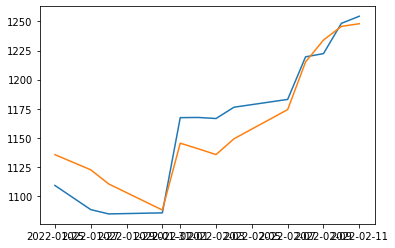

In [10]:
plt.plot(final_y_zeros.index[50:], (tf.squeeze(final_y_zeros[50:].to_numpy()).numpy())*k.values[0])
plt.plot(final_y_zeros.index[50:], preds)

In [12]:
model.save("GRU_tata steel")

INFO:tensorflow:Assets written to: GRU_tata steel\assets


INFO:tensorflow:Assets written to: GRU_tata steel\assets
